<a href="https://colab.research.google.com/github/mit1280/RAG_TUTORIAL/blob/main/Tutorial_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries

In [ ]:
!pip install -q transformers==4.38.2 langchain==0.1.13 llmsherpa==0.1.3 sentence-transformers==2.5.1 datasets==2.18.0
!pip install optimum auto-gptq "pinecone-client[grpc]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.1/407.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

## Import libraries

In [ ]:
import pandas as pd
import re
from llmsherpa.readers import LayoutPDFReader
from llmsherpa.readers.layout_reader import Paragraph
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import HTMLHeaderTextSplitter
from sentence_transformers import SentenceTransformer
import pinecone
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import datetime
from time import sleep
import os
from pinecone import Pinecone
import re
from pinecone import ServerlessSpec, PodSpec
import time

## Chunk all data

In [ ]:
llmsherpa_api_url = "https://readers.llmsherpa.com/api/document/developer/parseDocument?renderFormat=all"

# Hyper parameters for website data chunking
webpage_chunk_size = 1200
webpage_chunk_overlap = 30

In [ ]:
def read_pdf_and_chunking(source_link):
    pdf_text_df = pd.DataFrame()
    try:
        pdf_reader = LayoutPDFReader(llmsherpa_api_url)
        doc = pdf_reader.read_pdf(source_link)

        chunks = [i.to_text() for i in doc.chunks() if isinstance(i, Paragraph)]
        pdf_text_df = pd.DataFrame(chunks, columns=['chunks'])

        pdf_text_df['chunks'] = pdf_text_df['chunks'].apply(lambda x: re.sub(r'\n\n\s*(?=[a-z])', "\n", x))

        pdf_text_df['chunks'] = pdf_text_df['chunks'].str.replace("\n\n","\t").str.replace(",\n",",").str.replace("\n",' ').str.replace("\t","\n").str.strip()

        pdf_text_df['chunks'] = pdf_text_df['chunks'].apply(lambda x: re.sub("\s*\n+", "\n", x))

        print(f"Data has been Retrived from {source_link}")
    except Exception as e:
        # print(text)
        print(f"\nError {e} with {source_link}\n")

    return pdf_text_df

In [ ]:
text_df = pd.DataFrame()

for index, source_row in {1:'https://www.rbcroyalbank.com/rbcexpress/rbc-express-user-guide.pdf'}.items():
    temp_df = read_pdf_and_chunking(source_row)


    text_df = pd.concat([text_df, temp_df])

Data has been Retrived from https://www.rbcroyalbank.com/rbcexpress/rbc-express-user-guide.pdf


<Axes: >

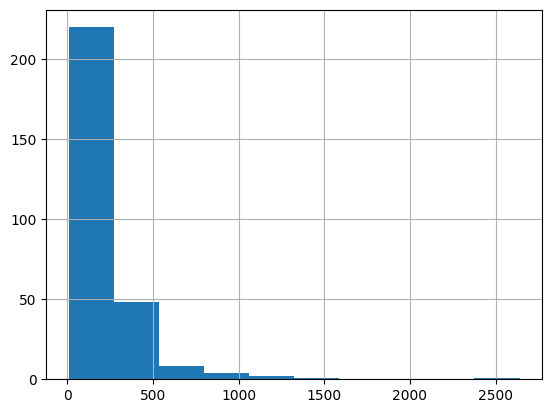

In [ ]:
text_df['chunks'].apply(len).hist()

In [ ]:
text_df.fillna('', inplace=True)

In [ ]:
text_df['chunks'] = text_df['chunks'].apply(lambda x: re.sub(" +", " ", x))

## Read Embedding Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
embed_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY', 'YOUR_API_KEY')
PINECONE_API_ENV = os.environ.get('PINECONE_API_ENV', 'gcp-starter') # You may need to switch with your env

## Create pinecone Index

In [ ]:
# Import the Pinecone class
# https://colab.research.google.com/github/pinecone-io/examples/blob/master/docs/semantic-search.ipynb#scrollTo=kT8pfoO46Iwg

# Create a Pinecone instance
pinecone = Pinecone(api_key=PINECONE_API_KEY)

# Set the index name
index_name = "demo"

In [ ]:
use_serverless = os.environ.get("USE_SERVERLESS", "False").lower() == "true"

In [ ]:
if use_serverless:
    spec = ServerlessSpec(cloud='aws', region='us-west-2')
else:
    spec = PodSpec(environment=PINECONE_API_ENV)

In [ ]:
existing_indexes = [
    index_info["name"] for index_info in pinecone.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pinecone.create_index(
        index_name,
        dimension=embed_model.get_sentence_embedding_dimension(),  # dimensionality of minilm
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pinecone.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pinecone.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.00284,
 'namespaces': {'': {'vector_count': 284}},
 'total_vector_count': 284}

In [ ]:
index

## Upsert data in Pinecone

In [ ]:
insert_df = text_df[text_df['chunks'].str.len()>0]

In [ ]:
insert_df.shape

(284, 1)

In [ ]:
insert_df.reset_index(drop=True, inplace=True)

In [ ]:
chunks = []
from uuid import uuid4
for idx, record in insert_df.iterrows():
    chunks.extend([{
        'id'           : str(uuid4()),
        'chunk_text'   : record['chunks'],
        'chunk'        : idx,
    } ])

### Set device to GPU

In [ ]:
batch_size = 100  # how many embeddings we create and insert at once

for i in tqdm(range(0, len(chunks), batch_size)):
    # find end of batch
    i_end = min(len(chunks), i+batch_size)
    meta_batch = chunks[i:i_end]
    # get ids
    ids_batch = [x['id'] for x in meta_batch]
    # get texts to encode
    texts = [x['chunk_text'] for x in meta_batch]
    # create embeddings (try-except added to avoid RateLimitError)
    try:
        embeds = embed_model.encode(texts)
    except:
        done = False
        while not done:
            sleep(5)
            try:
                embeds = embed_model.encode(texts)
                done = True
            except:
                pass
    # cleanup metadata
    meta_batch = [{
        'text'         : x['chunk_text'],
        'chunk'        : x['chunk'],
    } for x in meta_batch]
    to_upsert = list(zip(ids_batch, embeds, meta_batch))
    # upsert to Pinecone
    index.upsert(vectors=to_upsert)
print("Data Inserted")

  0%|          | 0/3 [00:00<?, ?it/s]

Data Inserted


In [ ]:
df_with_id = pd.DataFrame(chunks)
df_with_id.to_csv("useful_for_later.csv")

## Query Pinecone

In [ ]:
query_text = "When are you presented with USD and CAD during transfers?"
#Answer: Transportation 62%, with range 11kg to 666kg depending on travelling distance; food waste 25%

query_vector = embed_model.encode(query_text).tolist()
results = index.query(vector=query_vector, top_k = 1, include_metadata=True)

In [ ]:
[i['metadata'] for i in results['matches']]

[{'chunk': 84.0,
  'text': 'Note: When transferring between CAD and USD accounts you will be presented with a Foreign Exchange Conversion Estimate, including the estimated rate. If you are the only approver or final approver for the transaction, you will be required to accept a rate for same day transfers, if rates are available. When “Get a Rate” is selected, a timer will begin. You will need to accept a rate before the timer runs out or the rate will expire. After accepting a rate, another timer may begin to count down. If so you will need to successfully approve the transaction within the given time or the accepted rate will be lost.'}]

In [ ]:
retrived_text = "\n".join([i['metadata']['text'] for i in results['matches']])
retrived_text

'Note: When transferring between CAD and USD accounts you will be presented with a Foreign Exchange Conversion Estimate, including the estimated rate. If you are the only approver or final approver for the transaction, you will be required to accept a rate for same day transfers, if rates are available. When “Get a Rate” is selected, a timer will begin. You will need to accept a rate before the timer runs out or the rate will expire. After accepting a rate, another timer may begin to count down. If so you will need to successfully approve the transaction within the given time or the accepted rate will be lost.'

## Load LLM

In [ ]:
model_name_or_path = "TheBloke/openchat-3.5-0106-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
gen_model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to 

## Get Response

In [ ]:
# https://github.com/openai/openai-cookbook/blob/main/examples/fine-tuned_qa/ft_retrieval_augmented_generation_qdrant.ipynb
chat = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "Answer the following Question based on the Context only. Only answer from the Context and make it short in just one statement. If you don't know the answer, say 'I don't know.\
  Question: ###Q\n\n\
  Context: ###C\n\n\
  "}
  ]
prompt_new = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
prompt_new

"<s>GPT4 Correct System: You are a helpful assistant.<|end_of_turn|>GPT4 Correct User: Answer the following Question based on the Context only. Only answer from the Context and make it short in just one statement. If you don't know the answer, say 'I don't know.  Question: ###Q\n\n  Context: ###C\n\n  <|end_of_turn|>GPT4 Correct Assistant:"

In [ ]:
final_prompt = prompt_new.replace("###Q", query_text).replace("###C", retrived_text) + "Answer is \n"
final_prompt

"<s>GPT4 Correct System: You are a helpful assistant.<|end_of_turn|>GPT4 Correct User: Answer the following Question based on the Context only. Only answer from the Context and make it short in just one statement. If you don't know the answer, say 'I don't know.  Question: When are you presented with USD and CAD during transfers?\n\n  Context: Note: When transferring between CAD and USD accounts you will be presented with a Foreign Exchange Conversion Estimate, including the estimated rate. If you are the only approver or final approver for the transaction, you will be required to accept a rate for same day transfers, if rates are available. When “Get a Rate” is selected, a timer will begin. You will need to accept a rate before the timer runs out or the rate will expire. After accepting a rate, another timer may begin to count down. If so you will need to successfully approve the transaction within the given time or the accepted rate will be lost.\n\n  <|end_of_turn|>GPT4 Correct Assi

In [150]:
input_ids = tokenizer(final_prompt, return_tensors='pt').input_ids.cuda()
output = gen_model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=150)
print(tokenizer.decode(output[0]))

<s><s> GPT4 Correct System: You are a helpful assistant.<|end_of_turn|> GPT4 Correct User: Answer the following Question based on the Context only. Only answer from the Context and make it short in just one statement. If you don't know the answer, say 'I don't know.  Question: When are you presented with USD and CAD during transfers?

  Context: Note: When transferring between CAD and USD accounts you will be presented with a Foreign Exchange Conversion Estimate, including the estimated rate. If you are the only approver or final approver for the transaction, you will be required to accept a rate for same day transfers, if rates are available. When “Get a Rate” is selected, a timer will begin. You will need to accept a rate before the timer runs out or the rate will expire. After accepting a rate, another timer may begin to count down. If so you will need to successfully approve the transaction within the given time or the accepted rate will be lost.

  <|end_of_turn|> GPT4 Correct Ass